# **Empty Submissions vs Non-Empty Submissions**

In [1]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_final\\code\\preprocessing')

In [2]:
file_comments = "../../../data/reddit/NeutralPolitics_comments.zst"
file_submissions = "../../../data/reddit/NeutralPolitics_submissions.zst"

subreddit_here = "NeutralPolitics"
subreddit = "NeutralPolitics"


#output_path = f"output/{subreddit_here}_new_preprocessing_com_rep.csv"



In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain
import seaborn as sns

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
#import gurobipy
#from gurobipy import *

pd.options.mode.chained_assignment = None

In [4]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import plot_submissions_comments
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

In [5]:
# import data
data_comments = import_subreddit(file_comments)
data_submissions = import_subreddit(file_submissions)


In [6]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [7]:
df_submissions

,downs,link_flair_text,distinguished,media,url,link_flair_css_class,id,edited,num_reports,created_utc,...,upvote_ratio,is_created_from_ads_ui,retrieved_utc,top_awarded_type,call_to_action,url_overridden_by_dest,author_is_blocked,updated_on,previous_selftext,_meta
0,5.0,None,None,None,http://www.reddit.com/r/NeutralPolitics/commen...,None,ppufn,False,NaN,1329262119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,None,None,None,http://www.reddit.com/r/NeutralPolitics/commen...,None,pps91,False,NaN,1329259646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,None,None,None,http://www4.ncsu.edu/unity/lockers/users/f/fel...,None,pps8a,False,NaN,1329259624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,None,None,None,http://en.wikipedia.org/wiki/Network_neutrality,None,ppob6,False,NaN,1329255074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,None,None,None,http://www.reddit.com/r/NeutralPolitics/commen...,None,ppo5l,False,NaN,1329254921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22253,0.0,"A, B, C, D",None,None,https://www.reddit.com/r/NeutralPolitics/comme...,None,18skz25,False,0.0,1703737645.0,...,1.0,False,NaN,NaN,NaN,NaN,False,1.703738e+09,NaN,{'retrieved_2nd_on': 1703867281}
22254,0.0,D,None,None,https://www.reddit.com/r/NeutralPolitics/comme...,None,18sz579,False,0.0,1703783949.0,...,1.0,False,NaN,NaN,NaN,NaN,False,1.703784e+09,NaN,{'retrieved_2nd_on': 1703913560}
22255,0.0,"A, B, C, D",None,None,https://www.reddit.com/r/NeutralPolitics/comme...,None,18tplvh,False,0.0,1703863615.0,...,1.0,False,NaN,NaN,NaN,NaN,False,1.703864e+09,NaN,{'retrieved_2nd_on': 1703993225}
22256,0.0,"A, B, D",None,None,https://www.reddit.com/r/NeutralPolitics/comme...,None,18uc720,False,0.0,1703929731.0,...,1.0,False,NaN,NaN,NaN,NaN,False,1.703930e+09,NaN,{'retrieved_2nd_on': 1704059339}


In [8]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)
submissions

Nr. of pulled submissions 22258


,author,created_utc,id,num_comments,score,send_replies,stickied,subreddit,subreddit_id,title,name,likes,ups,category,selftext,type,date
24,PavementBlues,1.329185e+09,poewt,20,32,NaN,NaN,NeutralPolitics,t5_2tk0i,Tensions grow as Israel blames Iran for bombin...,t3_poewt,NaN,36.0,NaN,,submission,2012-02-14
23,PavementBlues,1.329189e+09,poi5n,22,125,NaN,NaN,NeutralPolitics,t5_2tk0i,"If you like the idea of r/NeutralPolitics, ple...",t3_poi5n,NaN,132.0,NaN,"...because seriously, Reddit needs more places...",submission,2012-02-14
22,logantauranga,1.329191e+09,pojs2,9,24,NaN,NaN,NeutralPolitics,t5_2tk0i,What percentage of unemployment is consistent ...,t3_pojs2,NaN,25.0,NaN,I understand that full employment is something...,submission,2012-02-14
21,PavementBlues,1.329195e+09,poney,9,26,NaN,NaN,NeutralPolitics,t5_2tk0i,A Thought on Federal Unions,t3_poney,NaN,26.0,NaN,I was recently presented with an interesting p...,submission,2012-02-14
20,slyfox117,1.329200e+09,por7b,8,27,NaN,NaN,NeutralPolitics,t5_2tk0i,Thoughts on Secession from the US,t3_por7b,NaN,30.0,NaN,I realize that the scope of this statement is ...,submission,2012-02-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22253,Sensitive_Ad_3448,1.703738e+09,18skz25,2,1,True,False,NeutralPolitics,t5_2tk0i,which side is better?,t3_18skz25,NaN,1.0,None,[removed],submission,2023-12-28
22254,Quick-Ad-4825,1.703784e+09,18sz579,2,1,True,False,NeutralPolitics,t5_2tk0i,Question on amendments,t3_18sz579,NaN,1.0,None,[removed],submission,2023-12-28
22255,discardafter99uses,1.703864e+09,18tplvh,1,1,True,False,NeutralPolitics,t5_2tk0i,"Theoretically, what would happen if neither Bi...",t3_18tplvh,NaN,1.0,None,[removed],submission,2023-12-29
22256,Cheezebaal,1.703930e+09,18uc720,1,1,True,False,NeutralPolitics,t5_2tk0i,Educate me,t3_18uc720,NaN,1.0,None,[removed],submission,2023-12-30


In [9]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)

Nr. of pulled comments & replies 578041


In [10]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

Nr. of comments 99234
Nr. of replies 94724


In [11]:
comments

,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,UncleNorman,1.329188e+09,poewt,2tk0i,Buy lots of iodine so when they nuke the crap ...,poewt,c3qzba0,c3qzba0,-9.0,-9,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,comment
1,amus,1.329194e+09,poewt,2tk0i,Honestly I think it is mostly posturing. \n\nT...,poewt,c3r0aqc,c3r0aqc,5.0,5,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,comment
2,click44,1.329194e+09,poewt,2tk0i,"I think we should talk to both sides and, at t...",poewt,c3r0cdo,c3r0cdo,-6.0,-6,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,comment
3,bharder,1.329194e+09,poi5n,2tk0i,A good way to drum up interest would be to get...,poi5n,c3r0cvi,c3r0cvi,6.0,6,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,comment
4,hersheyphys,1.329195e+09,poi5n,2tk0i,Oh I like this subreddit! Is there really no o...,poi5n,c3r0k9f,c3r0k9f,8.0,8,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99229,[deleted],1.703864e+09,18tplvh,2tk0i,[removed],18tplvh,kff7e86,kff7e86,1.0,1,0.0,NeutralPolitics,NaN,,False,True,NaN,2023-12-29,comment
99230,canekicker,1.703865e+09,18tplvh,2tk0i,Hello there. I'm a mod in /r/NeutralPolitics.\...,18tplvh,kffbbhx,kffbbhx,1.0,1,0.0,NeutralPolitics,NaN,,True,True,NaN,2023-12-29,comment
99231,[deleted],1.703930e+09,18uc720,2tk0i,[removed],18uc720,kfjd1go,kfjd1go,1.0,1,0.0,NeutralPolitics,NaN,,False,True,NaN,2023-12-30,comment
99232,canekicker,1.703944e+09,18uc720,2tk0i,Hello there. I'm a mod in /r/NeutralPolitics.\...,18uc720,kfjxiud,kfjxiud,1.0,1,0.0,NeutralPolitics,NaN,,True,True,NaN,2023-12-30,comment


In [12]:
replies

,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,[deleted],1.329192e+09,c3qzba0,2tk0i,[deleted],poewt,c3qzx0y,c3qzx0y,1.0,1,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,reply_1
1,slyfox117,1.329195e+09,c3r0aqc,2tk0i,You don't think that if there is an Iran/Israe...,poewt,c3r0hdr,c3r0hdr,3.0,3,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,reply_1
2,[deleted],1.329196e+09,c3r0aqc,2tk0i,[deleted],poewt,c3r0lti,c3r0lti,2.0,2,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,reply_1
3,[deleted],1.329196e+09,c3r0cdo,2tk0i,[deleted],poewt,c3r0mol,c3r0mol,6.0,6,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,reply_1
4,[deleted],1.329206e+09,c3r161p,2tk0i,[deleted],poi5n,c3r1zbx,c3r1zbx,8.0,8,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,reply_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94719,nosecohn,1.703839e+09,kfdifsa,2tk0i,This comment has been removed for violating [/...,17hqp49,kfe2j9e,kfe2j9e,1.0,1,0.0,NeutralPolitics,NaN,,False,True,NaN,2023-12-29,reply_1
94720,discardafter99uses,1.703867e+09,kffbbhx,2tk0i,Hi!\n\nSorry about that. Do you think you cou...,18tplvh,kffgj42,kffgj42,1.0,1,0.0,NeutralPolitics,NaN,,False,True,NaN,2023-12-29,reply_1
94721,AutoModerator,1.703903e+09,d573ark,2tk0i,Since this comment doesn't link to any [source...,4ruo7h,kfi2hbw,kfi2hbw,1.0,1,0.0,NeutralPolitics,NaN,,False,False,NaN,2023-12-30,reply_1
94722,[deleted],1.703940e+09,k874g6b,2tk0i,[removed],17pgvsm,kfjr973,kfjr973,1.0,1,0.0,NeutralPolitics,NaN,,False,True,NaN,2023-12-30,reply_1


<Axes: xlabel='count', ylabel='Density'>

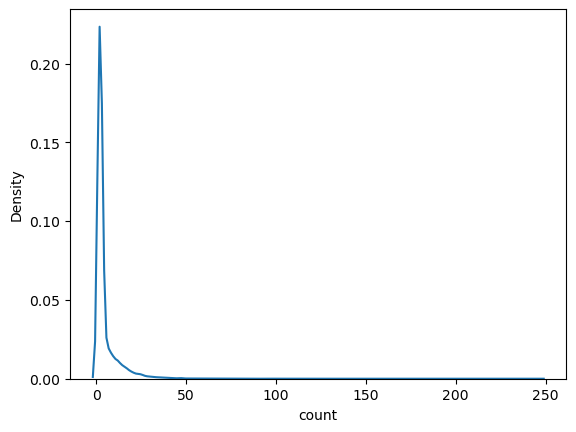

In [13]:
relevant_submissions = pd.DataFrame(comments.groupby('parent_id')['id'].count()).reset_index().rename(columns={'parent_id' : 'submission_id', 'id' : 'count'})
#print(relevant_submissions['count'].mean())
relevant_submissions

sns.kdeplot(relevant_submissions["count"])

In [14]:
# select relevant submissions (by avg. number of comments)

relevant_submissions, relevant_comments, empty_submissions, empty_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")


Mean nr. of comments per submission 4.721157048384795
Nr. of submission, that I have comments for 21019
All submissions found
Removing empty submissions deleted 15919 submissions
Empty submissions in df_submissions_empty: 15919
Kept 5100 submissions
Nr. of comments, whose submission is retaied 62506
Share 0.6298849184755225
Nr. of comments, whose submission is empty 36728
Share 0.3701150815244775


In [15]:
relevant_submissions

,author,created_utc,id,num_comments,score,send_replies,stickied,subreddit,subreddit_id,title,name,likes,ups,category,selftext,type,date
0,PavementBlues,1.329189e+09,poi5n,22,125,NaN,NaN,NeutralPolitics,t5_2tk0i,"If you like the idea of r/NeutralPolitics, ple...",t3_poi5n,NaN,132.0,NaN,"...because seriously, Reddit needs more places...",submission,2012-02-14
1,logantauranga,1.329191e+09,pojs2,9,24,NaN,NaN,NeutralPolitics,t5_2tk0i,What percentage of unemployment is consistent ...,t3_pojs2,NaN,25.0,NaN,I understand that full employment is something...,submission,2012-02-14
2,PavementBlues,1.329195e+09,poney,9,26,NaN,NaN,NeutralPolitics,t5_2tk0i,A Thought on Federal Unions,t3_poney,NaN,26.0,NaN,I was recently presented with an interesting p...,submission,2012-02-14
3,slyfox117,1.329200e+09,por7b,8,27,NaN,NaN,NeutralPolitics,t5_2tk0i,Thoughts on Secession from the US,t3_por7b,NaN,30.0,NaN,I realize that the scope of this statement is ...,submission,2012-02-14
4,PavementBlues,1.329200e+09,porjo,16,17,NaN,NaN,NeutralPolitics,t5_2tk0i,Suggestions for community guidelines.,t3_porjo,NaN,19.0,NaN,I want the moderation of this group to be as l...,submission,2012-02-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5095,unkz,1.698422e+09,17hqp49,1,1,True,False,NeutralPolitics,t5_2tk0i,What's the evidence about the advantages and d...,t3_17hqp49,NaN,1.0,None,Given the recent [mass shooting in Maine](http...,submission,2023-10-27
5096,Quick_Question_pl,1.698799e+09,17kzxuo,16,39,True,False,NeutralPolitics,t5_2tk0i,Resource Recommendations to learn about 2010's...,t3_17kzxuo,NaN,39.0,None,"Posting in a couple different subreddits, as I...",submission,2023-11-01
5097,blebaford,1.698803e+09,17l15gj,16,130,True,False,NeutralPolitics,t5_2tk0i,What is Egypt's role with respect to the flow ...,t3_17l15gj,NaN,130.0,None,An [October 19 article in the Economist](https...,submission,2023-11-01
5098,nosecohn,1.699315e+09,17pgvsm,1,1,False,False,NeutralPolitics,t5_2tk0i,How does the current level of world conflict c...,t3_17pgvsm,NaN,1.0,None,"Right now, there's active war in Ukraine and G...",submission,2023-11-07


In [16]:
#5100 non-empty submissions
# retained 4860 with comments and replies

# 15919 empty submissions only 3860 matched with commenta & replies

print(4860/5100)

print("With 4860 submissions, we build 66979 interactions, so on average", 66979/4860, "interactions per submission")

print(3869 / 15919)
print("With 3869 submissions, we build 9053  interactions, so on average", 9053 /3869, "interactions per submission")


0.9529411764705882
With 4860 submissions, we build 66979 interactions, so on average 13.781687242798354 interactions per submission
0.24304290470506942
With 3869 submissions, we build 9053  interactions, so on average 2.339881106229 interactions per submission


In [17]:
df_matched, com_per_sub, rep_per_com = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner', subreddit_here)
df_matched

Nr. of unique replies 66979
Nr. of unique comments 30453
Nr. of unique submissions 4860
A submission receives on average 6.26604938271605 comments.
A comment receives 0n average 2.199422060223952 replies.
Share of matched submissions: 0.9529411764705882


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c3r161p,c3r1zbx,[deleted],NeutralPolitics,1.329206e+09,[deleted],8.0,8,0.0,poi5n,...,Toptomcat,9.0,9,0.0,1.329199e+09,"...because seriously, Reddit needs more places...",PavementBlues,132.0,125,1.329189e+09
1,c3r2dgx,c3r2e7k,Employees at corporations get paid less by hav...,NeutralPolitics,1.329211e+09,bungerman,4.0,4,0.0,pot4h,...,DanParts,24.0,24,0.0,1.329211e+09,Is there any non-ideological evidence or reaso...,wassworth,21.0,18,1.329203e+09
2,c3r0vad,c3r2oex,"I've got to say, 3 percent unemployment is ext...",NeutralPolitics,1.329215e+09,This_isgonnahurt,6.0,6,0.0,pojs2,...,anonoman925,5.0,5,0.0,1.329197e+09,I understand that full employment is something...,logantauranga,25.0,24,1.329191e+09
3,c3r16lt,c3r2rxv,I agree with just about everything you said (e...,NeutralPolitics,1.329217e+09,This_isgonnahurt,3.0,3,0.0,pojs2,...,Kazmarov,7.0,7,0.0,1.329200e+09,I understand that full employment is something...,logantauranga,25.0,24,1.329191e+09
4,c3r1lrl,c3r2tml,I don't think the comparison to the US civil w...,NeutralPolitics,1.329218e+09,slyfox117,5.0,5,0.0,por7b,...,DublinBen,12.0,12,0.0,1.329203e+09,I realize that the scope of this statement is ...,slyfox117,30.0,27,1.329200e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66974,kfdk9pp,kfdk9s6,Since this comment doesn't link to any [source...,NeutralPolitics,1.703828e+09,AutoModerator,1.0,1,0.0,13uzvsx,...,kibufox,1.0,1,0.0,1.703828e+09,There are currently 7 candidates who have anno...,Lux_Aquila,154.0,154,1.685379e+09
66975,kfdifsa,kfe2j9e,This comment has been removed for violating [/...,NeutralPolitics,1.703839e+09,nosecohn,1.0,1,0.0,17hqp49,...,[deleted],1.0,1,0.0,1.703827e+09,Given the recent [mass shooting in Maine](http...,unkz,1.0,1,1.698422e+09
66976,d573ark,kfi2hbw,Since this comment doesn't link to any [source...,NeutralPolitics,1.703903e+09,AutoModerator,1.0,1,0.0,4ruo7h,...,ybezmenov,1.0,1,NaN,1.468186e+09,There seems great emphasis here on Reddit on t...,Prufrock01,8.0,8,1.467985e+09
66977,k874g6b,kfjr973,[removed],NeutralPolitics,1.703940e+09,[deleted],1.0,1,0.0,17pgvsm,...,SeasickSeal,15.0,15,0.0,1.699354e+09,"Right now, there's active war in Ukraine and G...",nosecohn,1.0,1,1.699315e+09


In [18]:
com_per_sub
rep_per_com

,msg_id_parent,0
0,c3r0cvi,1
1,c3r0k9f,2
2,c3r0vad,2
3,c3r161p,2
4,c3r16lt,2
...,...,...
30448,ke7ynj1,1
30449,kem7n9w,2
30450,kfcov22,1
30451,kfdifsa,1


In [19]:
com_per_sub
#sns.kdeplot(com_per_sub[0])
#sns.kdeplot(rep_per_com[0])



,submission_id,0
0,100o2j,9
1,101xz3,1
2,104vl0y,4
3,105dgg,9
4,106bwl,6
...,...,...
4855,zx8cc,1
4856,zxddl,7
4857,zxfpo,13
4858,zyza2,1


In [20]:
df_matched_empty, com_per_sub_empty, rep_per_com_empty = match_reply_comment_submission(replies, empty_comments, empty_submissions, 'inner', subreddit_here)
df_matched_empty

Nr. of unique replies 9053
Nr. of unique comments 6287
Nr. of unique submissions 3860
A submission receives on average 1.6287564766839377 comments.
A comment receives 0n average 1.4399554636551615 replies.
Share of matched submissions: 0.24247754255920598


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c3qzba0,c3qzx0y,[deleted],NeutralPolitics,1.329192e+09,[deleted],1.0,1,0.0,poewt,...,UncleNorman,-9.0,-9,0.0,1.329188e+09,,PavementBlues,36.0,32,1.329185e+09
1,c3r0aqc,c3r0hdr,You don't think that if there is an Iran/Israe...,NeutralPolitics,1.329195e+09,slyfox117,3.0,3,0.0,poewt,...,amus,5.0,5,0.0,1.329194e+09,,PavementBlues,36.0,32,1.329185e+09
2,c3r0aqc,c3r0lti,[deleted],NeutralPolitics,1.329196e+09,[deleted],2.0,2,0.0,poewt,...,amus,5.0,5,0.0,1.329194e+09,,PavementBlues,36.0,32,1.329185e+09
3,c3r0cdo,c3r0mol,[deleted],NeutralPolitics,1.329196e+09,[deleted],6.0,6,0.0,poewt,...,click44,-6.0,-6,0.0,1.329194e+09,,PavementBlues,36.0,32,1.329185e+09
4,c3r3y1g,c3r52y4,I just woke up and saw this post. Absolutely a...,NeutralPolitics,1.329237e+09,PavementBlues,0.0,0,0.0,pp0uz,...,yknowyerman,6.0,6,0.0,1.329230e+09,,tesseracter,12.0,7,1.329224e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9048,kd77vkg,kd7907o,How can I fix it,NeutralPolitics,1.702487e+09,No_Gene677,1.0,1,0.0,18h98v1,...,nosecohn,1.0,1,0.0,1.702487e+09,[removed],No_Gene677,1.0,1,1.702444e+09
9049,kdn7qzn,kdn8ash,I just tried to find it and it says it’s a pri...,NeutralPolitics,1.702751e+09,No_Paramedic_3322,1.0,1,0.0,18jx1sp,...,nosecohn,1.0,1,0.0,1.702751e+09,[removed],No_Paramedic_3322,1.0,1,1.702750e+09
9050,kdmil5o,kdonile,Gotcha thanks!,NeutralPolitics,1.702770e+09,misterbowfinger,1.0,1,0.0,18jrhqz,...,nosecohn,2.0,2,0.0,1.702742e+09,[removed],misterbowfinger,1.0,1,1.702734e+09
9051,kemkxqr,kemljoo,"Thank you, I wasn’t aware you guys already mad...",NeutralPolitics,1.703350e+09,vick2djax,2.0,2,0.0,18p6wxm,...,nosecohn,1.0,1,0.0,1.703349e+09,[removed],vick2djax,1.0,1,1.703342e+09


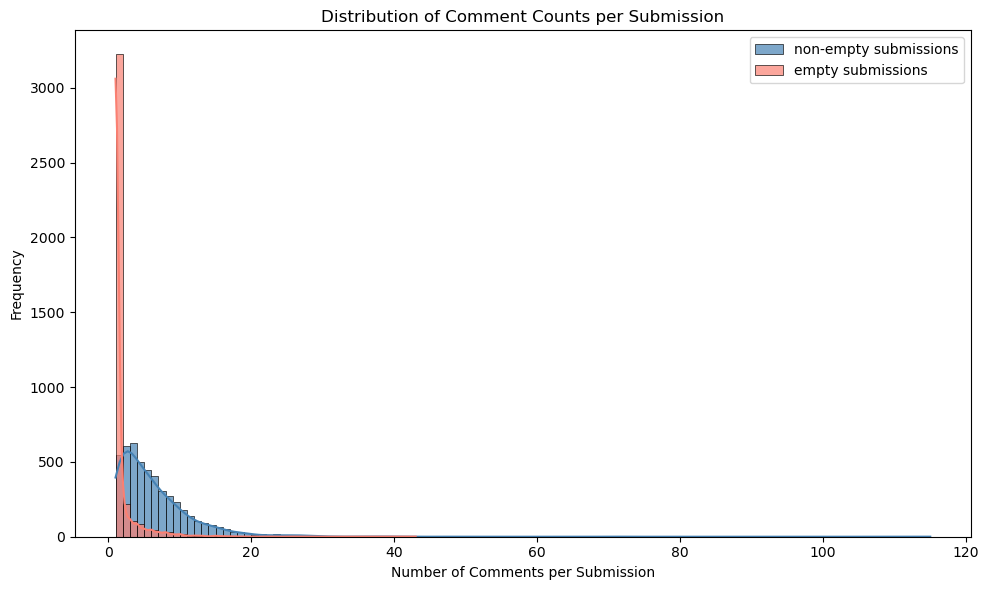

In [21]:

plt.figure(figsize=(10, 6))

sns.histplot(com_per_sub[0], binwidth=1, kde=True, label='non-empty submissions', color='steelblue', alpha=0.7)
sns.histplot(com_per_sub_empty[0], binwidth=1, kde=True, label='empty submissions', color='salmon', alpha=0.7)

plt.xlabel('Number of Comments per Submission')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Counts per Submission')
plt.legend()
plt.tight_layout()
plt.show()

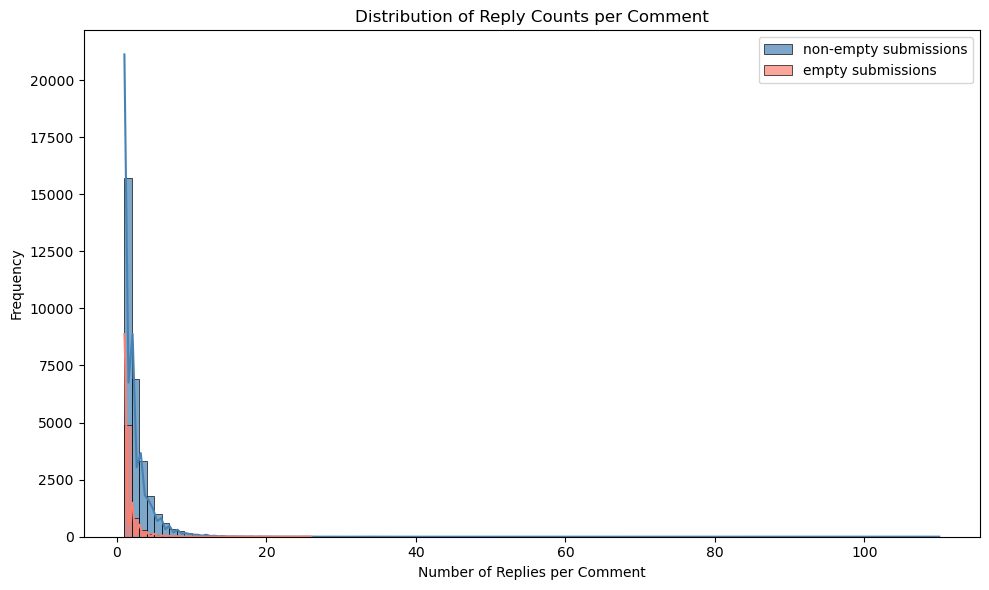

In [30]:

plt.figure(figsize=(10, 6))


sns.histplot(rep_per_com[0], binwidth=1, kde=True, label='non-empty submissions', color='steelblue', alpha=0.7)
sns.histplot(rep_per_com_empty[0], binwidth=1, kde=True, label='empty submissions', color='salmon', alpha=0.7)


plt.xlabel('Number of Replies per Comment')
plt.ylabel('Frequency')
plt.title('Distribution of Reply Counts per Comment')
plt.legend()
plt.tight_layout()
plt.show()